In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import pandas as pd
import os
from PIL import Image
from copy import deepcopy
from PIL import Image
import numpy as np

# 재현성을 위한 랜덤 시드 설정
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)  # 원하는 시드 값으로 설정

# Dataset 정의
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = int(self.annotations.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

# 테스트 데이터셋 정의
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.file_names = os.listdir(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.file_names[idx])
        image = Image.open(img_name).convert('RGB')
        
        if self.transform:
            image = self.transform(image)

        return image, self.file_names[idx]

# 하이퍼파라미터 설정
num_epochs = 10
num_classes = 17  # 클래스 수에 맞게 변경
batch_size = 16
learning_rate = 0.001

# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# 학습 데이터셋 로드
train_dataset = CustomDataset(csv_file='cv_challenge/train.csv', root_dir='cv_challenge/opencv_train_ver1', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 모델 정의
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to('cuda')

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 모델 학습
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to('cuda'), labels.to('cuda')

        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

# 모델 저장
torch.save(model.state_dict(), 'opencv_train_ver1_resnet18.pth')
print('Model saved as opencv_train_ver1_resnet18.pth')

# 테스트 데이터셋 로드
test_dataset = TestDataset(root_dir='cv_challenge/opencv_train_ver1_test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 모델 로드
model.load_state_dict(torch.load('opencv_train_ver1_resnet18.pth'))
model.eval()

# 예측 수행
predictions = []
with torch.no_grad():
    for images, file_names in test_loader:
        images = images.to('cuda')
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        for file_name, prediction in zip(file_names, predicted):
            predictions.append({
                'ID': file_name,
                'target': prediction.item()
            })

# 예측 결과를 DataFrame으로 변환하고 저장
submission_df = pd.DataFrame(predictions)
submission_df.to_csv('sample_submission.csv', index=False)
print('Predictions saved to sample_submission.csv')

C:\Users\master\anaconda3\envs\EDA\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\master\anaconda3\envs\EDA\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.7354077008938549
Epoch 2, Loss: 0.3691327869139536
Epoch 3, Loss: 0.3081776894666631
Epoch 4, Loss: 0.24435024057524374
Epoch 5, Loss: 0.16971596737740316
Epoch 6, Loss: 0.12021724151851929
Epoch 7, Loss: 0.17332718350143747
Epoch 8, Loss: 0.11406749889438013
Epoch 9, Loss: 0.051475270821200216
Epoch 10, Loss: 0.035493936455535766
Model saved as opencv_train_ver1_resnet18.pth
Predictions saved to sample_submission.csv


In [5]:
train_data = train_dataset.annotations
train_data.to_csv(f'opencv_train_ver1_resnet18.csv', index=False)

C:\Users\master\anaconda3\envs\EDA\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\master\anaconda3\envs\EDA\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


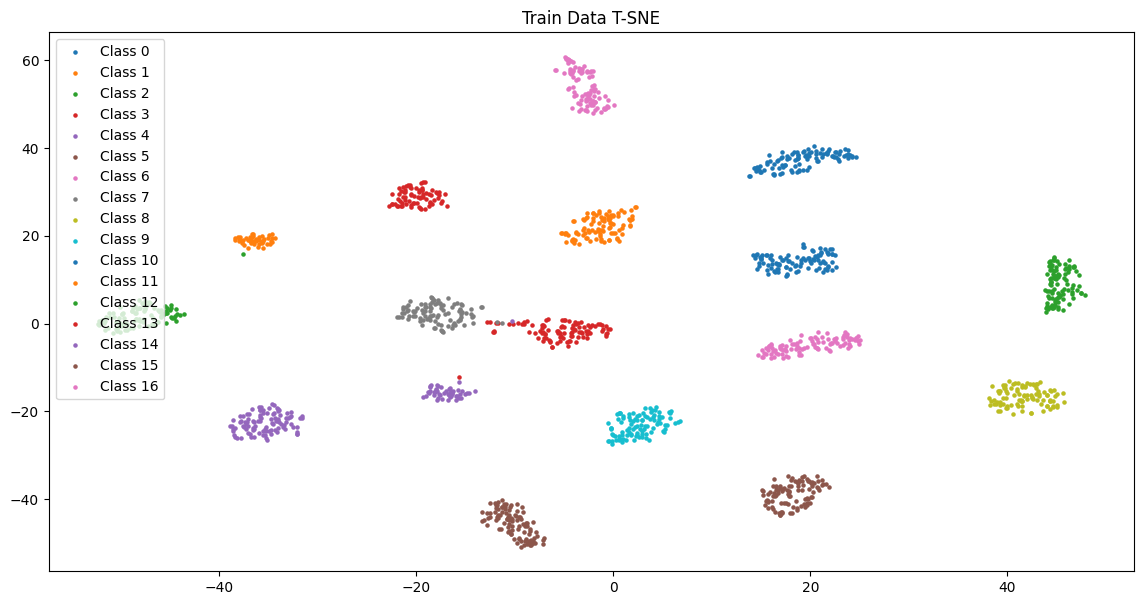

In [8]:
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, models
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
import numpy as np

# 하이퍼파라미터 설정
batch_size = 16
num_classes = 17  # 클래스 수에 맞게 변경


def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)


# Dataset 정의
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_name)
        label = int(self.annotations.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

# 하이퍼파라미터 설정
batch_size = 16

# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 데이터셋 로드
dataset = CustomDataset(csv_file='cv_challenge/train.csv', root_dir='cv_challenge/opencv_train_ver1', transform=transform)

best_model_name = 'resnet18'
best_fold = 3

# 가장 높은 정확도를 기록한 fold 데이터 로드
train_data = pd.read_csv('opencv_train_ver1_resnet18.csv')

train_indices = train_data.index.tolist()

train_subset = Subset(dataset, train_indices)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)


# 모델 리스트 정의
def get_model(model_name):
    if model_name == 'resnet18':
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model


# 최상의 모델 로드
model = get_model(best_model_name)
if best_model_name == 'resnet18':
    model.fc = nn.Linear(model.fc.in_features, num_classes)
elif best_model_name == 'vgg16':
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
elif best_model_name == 'efficientnet_b0':
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

model.load_state_dict(torch.load('opencv_train_ver1_resnet18.pth'))
model = model.to('cuda')
model.eval()

# 피처 추출 함수
def extract_features(loader, model):
    features = []
    labels = []
    with torch.no_grad():
        for images, lbls in loader:
            images = images.to('cuda')
            outputs = model(images)
            features.append(outputs.cpu().numpy())
            labels.append(lbls.numpy())
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels

# 학습 및 검증 데이터에 대해 피처 추출
train_features, train_labels = extract_features(train_loader, model)


# T-SNE 적용
tsne = TSNE(n_components=2, random_state=42)
train_tsne_results = tsne.fit_transform(train_features)


# 시각화
plt.figure(figsize=(14, 7))

# 학습 데이터 T-SNE
plt.subplot(1, 1, 1)
for class_id in range(num_classes):
    indices = train_labels == class_id
    plt.scatter(train_tsne_results[indices, 0], train_tsne_results[indices, 1], label=f'Class {class_id}', s=5)
plt.legend()
plt.title('Train Data T-SNE')


plt.show()